# Trabalho 05 - Parte 02

### Objetivo

- Aproximar RNN do LSTM

### Detalhe

Encontrar uma forma com o RNN de chegar a um resultado próximo do exibido com LSTM

## Observação

Para efeitos práticos o dataset só será importado uma única vez, para evitar code smell

### Código original


Importando o dataset

In [ ]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

In [ ]:
print(df.columns)

Index(['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather', 'temp', 'feel_temp', 'humidity', 'windspeed', 'count'],
      dtype='object')


Gráfico

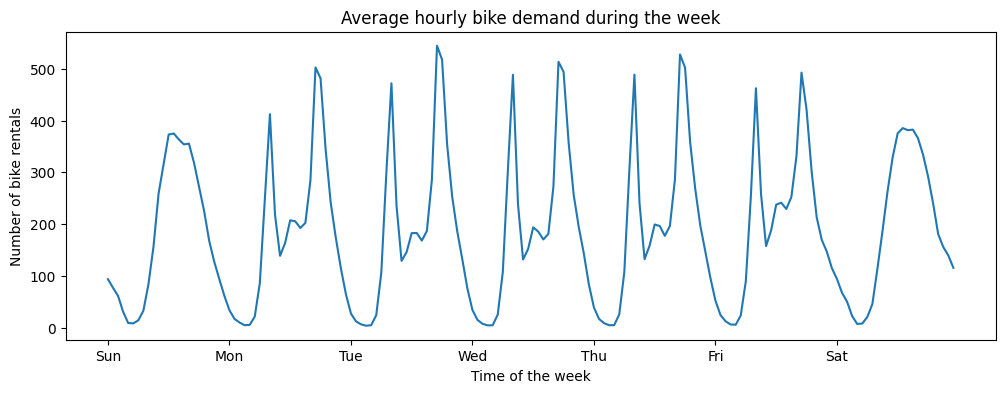

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

### Versão com LSTM

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

Pré-processamento

In [ ]:
# Corrigir tipos se necessário
df[['year', 'month', 'hour']] = df[['year', 'month', 'hour']].astype(int)

# Criar uma coluna de data/hora
df['full_date'] = pd.to_datetime('2011-01-01') + pd.to_timedelta(
    (df['year'] * 365 + (df['month'] - 1) * 30 + df['hour'] / 24), unit='D'
)

df.sort_values('full_date', inplace=True)

# Criar série temporal
data = df[['full_date', 'count']].copy()
data.set_index('full_date', inplace=True)

# Normalizar os valores
scaler = MinMaxScaler()
data['count_scaled'] = scaler.fit_transform(data[['count']])

# Criar janelas temporais
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24 horas
series = data['count_scaled'].values
X, y = create_sequences(series, window_size)

# Ajustar formato para LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

Data splitting

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Modelo LSTM

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinamento do modelo

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0110 - val_loss: 0.0171
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0087 - val_loss: 0.0173
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0087 - val_loss: 0.0172
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0085 - val_loss: 0.0174
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0085 - val_loss: 0.0187
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0085 - val_loss: 0.0172
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0085 - val_loss: 0.0173
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0087 - val_loss: 0.0177
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0086 - val_loss: 0.0171
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0082 - val_loss: 0.0174


Gráfico

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
RMSE: 135.63


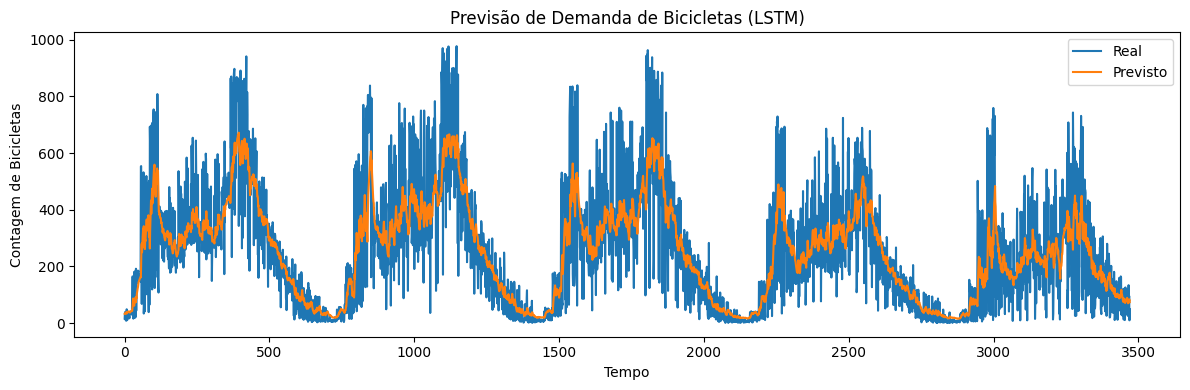

In [ ]:
# Prever
y_pred = model.predict(X_test)

# Reverter normalização
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calcular erro
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE: {rmse:.2f}")

# Resultado
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.title('Previsão de Demanda de Bicicletas (LSTM)')
plt.xlabel('Tempo')
plt.ylabel('Contagem de Bicicletas')
plt.legend()
plt.tight_layout()
plt.show()


### Versão com RNN

Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

Pré-processamento

In [ ]:
# Garantir que os campos estão como inteiros
df[['year', 'month', 'hour']] = df[['year', 'month', 'hour']].astype(int)

# Criar data completa
df['full_date'] = pd.to_datetime('2011-01-01') + pd.to_timedelta(
    (df['year'] * 365 + (df['month'] - 1) * 30 + df['hour'] / 24), unit='D'
)
df.sort_values('full_date', inplace=True)

# Selecionar apenas a série temporal da contagem
data = df[['full_date', 'count']].copy()
data.set_index('full_date', inplace=True)

# Normalizar
scaler = MinMaxScaler()
data['count_scaled'] = scaler.fit_transform(data[['count']])

# Criar janelas temporais
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 24
series = data['count_scaled'].values
X, y = create_sequences(series, window_size)

X = X.reshape((X.shape[0], X.shape[1], 1))

Data Splitting

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

Modelo RNN

In [ ]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Treinamento do modelo

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Gráfico

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0116 - val_loss: 0.0177
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0089 - val_loss: 0.0187
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0089 - val_loss: 0.0195
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0086 - val_loss: 0.0200
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0088 - val_loss: 0.0178
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0087 - val_loss: 0.0181
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0087 - val_loss: 0.0190
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0086 - val_loss: 0.0177
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0086 - val_loss: 0.0180
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0088 - val_loss: 0.0171
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE (RNN): 136.55


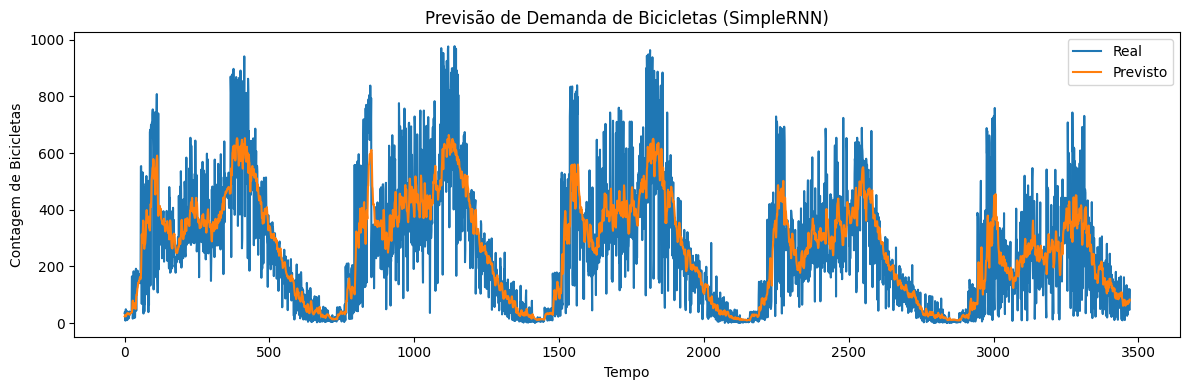

In [ ]:
# Prever
y_pred = model.predict(X_test)

# Reverter escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Avaliação
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE (RNN): {rmse:.2f}")

# Visualizar
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.title('Previsão de Demanda de Bicicletas (SimpleRNN)')
plt.xlabel('Tempo')
plt.ylabel('Contagem de Bicicletas')
plt.legend()
plt.tight_layout()
plt.show()